# AI based HR Policy Assistant
#### Human In Loop Example
###### Answer HR policy related questions only


In [2]:
!pip install langgraph langchain-openai langchain-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.4/142.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 13.9 MB/s eta 0:00:00


In [129]:
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableLambda


In [130]:
from google.colab import userdata
# Retrieve the API key from Colab's secrets
api_key = userdata.get('openai_api_key')

In [131]:
# 1. Define policy documents as an in-memory dictionary
policy_documents = {
    "leave_policy": "Employees are entitled to 20 paid leave days per year. Additional unpaid leave can be requested with manager approval.",
    "work_hours": "Regular work hours are from 9 AM to 6 PM, Monday to Friday. Flexible work hours are allowed with prior approval.",
    "remote_work": "Employees can work remotely up to 3 days a week. Full remote work requires special approval.",
}

In [132]:
# 2. Simple retriever based on keywords
def extract_policy(state):
    question = state["question"].lower()
    if "leave" in question:
        return {"question": state["question"], "context": policy_documents["leave_policy"], "found": True}
    elif "work hours" in question or "timing" in question:
        return {"question": state["question"], "context": policy_documents["work_hours"], "found": True}
    elif "remote" in question or "work from home" in question:
        return {"question": state["question"], "context": policy_documents["remote_work"], "found": True}
    else:
        return {"question": state["question"], "context": "", "found": False}

In [133]:
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=api_key)

In [134]:
# Responder node with OpenAI
def generate_response(state):
    prompt = f"Context: {state['context']}\nQuestion: {state['question']}\nAnswer concisely based on the provided context."
    response = llm.invoke(prompt)
    return {"question": state["question"], "context": state["context"], "response": response.content}


In [135]:
# Fallback node if no policy is matched
def fallback_response(state):
    prompt = f"The question is: '{state['question']}'. Apologize and inform the user that no matching policy was found, and ask them to rephrase."
    response = llm.invoke(prompt)
    print(response.content)

    new_question = input("❓ Please rephrase your question: ")
    return {"question": new_question, "context": "", "found": False}


In [136]:
# Router node to decide branching
def route_based_on_match(state):
    # Add a key to route by, but keep the full state intact
    state["next"] = "Responder" if state.get("found") else "Fallback"
    return state


In [137]:
# 4. Build LangGraph with retriever and responder
builder = StateGraph(dict)

builder.add_node("PolicySearch", RunnableLambda(extract_policy))
builder.add_node("Router", RunnableLambda(route_based_on_match))
builder.add_node("Responder", RunnableLambda(generate_response))
builder.add_node("Fallback", RunnableLambda(fallback_response))

builder.set_entry_point("PolicySearch")

builder.add_edge("PolicySearch", "Router")
builder.add_conditional_edges(
    "Router",
    lambda state: state["next"],  # extract the next step from router's output
    {
        "Responder": "Responder",
        "Fallback": "Fallback"
    }
)
builder.add_edge("Fallback", "PolicySearch")  # Cycle back instead of ending
builder.add_edge("Responder", END)

graph = builder.compile()


In [138]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

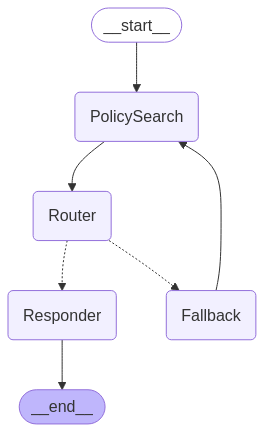

In [139]:
# Visualize using Mermaid
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [140]:
# 5. Example usage

result = graph.invoke({"question": "define program"})
print(result["response"])

I apologize, but I couldn't find a matching policy for your request. Could you please rephrase your question or provide more details? Thank you!
❓ Please rephrase your question: I need leave for 5 days. what to do?
You can use your paid leave for 5 days, or if you prefer, request unpaid leave from your manager for those days.
